## Grid Forming Inverter Test

In [1]:
import sys, os

notebook_dir = os.path.abspath('')
dpsim_root_dir = os.path.join(notebook_dir, "../../..")

sys.path.insert(0, os.path.join(dpsim_root_dir, 'python/src/dpsim'))
sys.path.insert(0, os.path.join(dpsim_root_dir, 'build'))

import dpsimpy

import matplotlib.pyplot as plt
import numpy as np
from villas.dataprocessing.readtools import *
from villas.dataprocessing.timeseries import *

#%matplotlib widget

### Parameterization

In [2]:
# Yazdani

nominal_frequency = 60
nominal_omega = 2 * np.pi * nominal_frequency
nominal_voltage = 400

# Line parameters (R/X = 1)
length = 5
line_resistance = 0.5 * length
line_inductance = 0.5 / nominal_frequency * length
line_capacitance = 50e-6 / nominal_frequency * length
line_resistance = 0.88e-3
line_inductance = 0

# VSI nominal values
vsi_nominal_voltage = 400
vsi_nominal_activePower = 900e6
vsi_nominal_reactivePower = 900e6
vsi_nominal_apparentPower = np.sqrt(vsi_nominal_activePower**2 + vsi_nominal_reactivePower**2)

# Droop controller parameters
        
# VSI filter parameters 
Lf = 100e-6
Cf = 2.5e-3
Rf = 2.07e-3
tau = 0.5e-3
Rc = 1e-5 #connecting resistor to external network
        
# Load Parameters
loadRes1 = 83e-3
loadInd1 = 137e-6
load1_s = nominal_voltage**2 / complex(loadRes1, 0-loadInd1 * nominal_omega)

# Switch Parameters
switch_open = 1e15
switch_closed = 0.25

# VSI Voltage controller parameters
controller_parameters = dpsimpy.signal.VSIControlType2Parameters()
controller_parameters.VdRef = nominal_voltage
controller_parameters.VqRef = 0
controller_parameters.Kpv = 1.6725
controller_parameters.Kiv = 374.64
controller_parameters.Kpc = 0.2
controller_parameters.Kic = 4.14
controller_parameters.Cf = Cf
controller_parameters.Lf = Lf
controller_parameters.omegaNom = nominal_omega
controller_parameters.tau = 0.001

'''
#DC Link source parameters
#Capacitance in pu
Cdc_pu=0.1
# Proportional coefficient K_p in pu
K_p_dc_pu=1.2
# Integral coefficient K_i in pu/s
K_i_dc_pu=2.4
#parametrisation of DC link&source and conversion from pu
dclink_parameters = dpsimpy.signal.DCLinkSourceParameters()
dclink_parameters.Kpdc=K_p_dc_pu*vsi_nominal_apparentPower/(vsi_nominal_voltage**2)
dclink_parameters.Kidc=K_i_dc_pu*vsi_nominal_apparentPower/(vsi_nominal_voltage**2)
dclink_parameters.Cdc=Cdc_pu*vsi_nominal_apparentPower/(nominal_omega*vsi_nominal_voltage**2)
dclink_parameters.Vdcnom=2*vsi_nominal_voltage
'''

#parametrisation of DC link&source and conversion from pu
dclink_parameters = dpsimpy.signal.DCLinkSourceParameters()
dclink_parameters.Kpdc=9.545942e+03
dclink_parameters.Kidc=1.909188e+03
dclink_parameters.Cdc=0.01
dclink_parameters.Vdcnom=800

### PF for initialization

In [3]:
sim_name_pf = "GridFormingInverter_Line_Load_PF"
dpsimpy.Logger.set_log_dir("logs/" + sim_name_pf)

### Nodes
gnd_pf = dpsimpy.sp.SimNode.gnd
n1_pf  = dpsimpy.sp.SimNode('n1', dpsimpy.PhaseType.Single)
n2_pf  = dpsimpy.sp.SimNode('n2', dpsimpy.PhaseType.Single)

### Components

# inverter as synchron generator
gen_pf = dpsimpy.sp.ph1.SynchronGenerator('VSI', dpsimpy.LogLevel.info)
gen_pf.set_parameters(rated_apparent_power = vsi_nominal_apparentPower, rated_voltage = vsi_nominal_voltage, 
                      set_point_active_power = 1.0, set_point_voltage = vsi_nominal_voltage, 
                      powerflow_bus_type=dpsimpy.PowerflowBusType.VD)
gen_pf.set_base_voltage(nominal_voltage)
gen_pf.modify_power_flow_bus_type(dpsimpy.PowerflowBusType.VD)

# PiLine
pi_line_pf = dpsimpy.sp.ph1.PiLine('PiLine', dpsimpy.LogLevel.info)
pi_line_pf.set_parameters(R=line_resistance, L=1e-9, C=0, G=0)
pi_line_pf.set_base_voltage(nominal_voltage)

# Load
load1_pf = dpsimpy.sp.ph1.Load('Load1', dpsimpy.LogLevel.info)
load1_pf.set_parameters(load1_s.real, load1_s.imag, vsi_nominal_voltage)

### Connections
gen_pf.connect([n1_pf])
pi_line_pf.connect([n2_pf, n1_pf])
load1_pf.connect([n2_pf])
    
### Define system topology
system_pf = dpsimpy.SystemTopology(nominal_frequency, [n1_pf, n2_pf], [gen_pf, pi_line_pf, load1_pf])

# Logging
logger_pf = dpsimpy.Logger(sim_name_pf)
logger_pf.log_attribute('n1.v', 'v', n1_pf)
logger_pf.log_attribute('n2.v', 'v', n2_pf)

sim_pf = dpsimpy.Simulation(sim_name_pf, dpsimpy.LogLevel.info)
sim_pf.set_system(system_pf)
sim_pf.set_domain(dpsimpy.Domain.SP)
sim_pf.set_solver(dpsimpy.Solver.NRP)
sim_pf.set_solver_component_behaviour(dpsimpy.SolverBehaviour.Initialization)
sim_pf.set_time_step(0.1)
sim_pf.set_final_time(0.2)
sim_pf.add_logger(logger_pf)
sim_pf.run()

[12:02:47.958004 GridFormingInverter_Line_Load_PF info] Initialize simulation: GridFormingInverter_Line_Load_PF
[12:02:47.958380 GridFormingInverter_Line_Load_PF info] Scheduling tasks.
[12:02:47.958455 GridFormingInverter_Line_Load_PF info] Scheduling done.
[12:02:47.958456 GridFormingInverter_Line_Load_PF info] Opening interfaces.
[12:02:47.958457 GridFormingInverter_Line_Load_PF info] Start synchronization with remotes on interfaces
[12:02:47.958458 GridFormingInverter_Line_Load_PF info] Synchronized simulation start with remotes
[12:02:47.958460 GridFormingInverter_Line_Load_PF info] Start simulation: GridFormingInverter_Line_Load_PF
[12:02:47.958463 GridFormingInverter_Line_Load_PF info] Time step: 1.000000e-01
[12:02:47.958464 GridFormingInverter_Line_Load_PF info] Final time: 2.000000e-01
[12:02:47.958601 GridFormingInverter_Line_Load_PF info] Simulation calculation time: 0.000135
[12:02:47.958625 GridFormingInverter_Line_Load_PF info] Simulation finished.


### Function for Dynamic Simulations

In [4]:
def gridFormingInverter_Line_Load(domain, system_pf, final_time=5, model_as_current_source=False, time_step=0.001):
    
    # get the correct module to be used (dpsimpy.sp, dpsimpy.dp or dpsimpy.emt) 
    dpsimpy_components = None
    if domain=="EMT":
        dpsimpy_components = dpsimpy.emt.ph3
        dpsimpy_components.SimNode = getattr(dpsimpy.emt, "SimNode")
    elif domain=="SP":
        dpsimpy_components = dpsimpy.sp.ph1
        dpsimpy_components.SimNode = getattr(dpsimpy.sp, "SimNode")
    else:
        domain = "DP"
        dpsimpy_components = dpsimpy.dp.ph1
        dpsimpy_components.SimNode = getattr(dpsimpy.dp, "SimNode") 
            
    name = "GridFormingInverter_Line_Load_" + domain
    dpsimpy.Logger.set_log_dir("logs/" + name)

    ### Nodes
    n1 = None
    n2 = None
    if (domain == "EMT"):      
        n1 = dpsimpy_components.SimNode('n1', dpsimpy.PhaseType.ABC)
        n2 = dpsimpy_components.SimNode('n2', dpsimpy.PhaseType.ABC)
    else:
        n1 = dpsimpy_components.SimNode('n1', dpsimpy.PhaseType.Single)
        n2 = dpsimpy_components.SimNode('n2', dpsimpy.PhaseType.Single)

    ### Components
    log_level = dpsimpy.LogLevel.info
    
    # voltage source inverter
    vsi = dpsimpy_components.VSIVoltageControlDQ(uid="VSI", name="VSI", loglevel=log_level, 
                                                with_interface_resistor=False,
                                                model_as_current_source=model_as_current_source)
    vsi.set_parameters(sys_omega=nominal_omega, vdref=vsi_nominal_voltage, vqref=0)
    vsi.set_filter_parameters(Lf=Lf, Cf=Cf, Rf=Rf, Rc=Rc)
    
    # vsi controller
    vsi_controller = None
    vsi_controller = dpsimpy.signal.VSIControlType2(name="VSIController", loglevel=log_level)
    vsi_controller.set_parameters(controller_parameters)
    vsi.add_vsi_controller(vsi_controller)

    # vsi dc link
    dc_link=None
    dc_link=dpsimpy.signal.DCLinkSource(name="DCLinkSource", loglevel=log_level)
    dc_link.set_parameters(dclink_parameters)
    vsi.add_dc_link(dc_link)

    # pi line
    """
    pi_line = dpsimpy_components.PiLine('PiLine', log_level)
    pi_line.set_parameters(series_resistance=line_resistance,
                            series_inductance=1e-9,
                            parallel_capacitance=0,
                            parallel_conductance=0)
    """
    pi_line = dpsimpy_components.Resistor('Resistor', log_level)
    if (domain == "EMT"):
        pi_line.set_parameters(R=dpsimpy.Math.single_phase_parameter_to_three_phase(line_resistance))
    else:
        pi_line.set_parameters(R=line_resistance)

    # Load 1
    load1 = None
    if (domain == "SP"):
        load1 = dpsimpy_components.Load('Load1', log_level)
    else:
        load1 = dpsimpy_components.RXLoad('Load1', log_level)
    load1.set_parameters(active_power=load1_s.real, reactive_power=load1_s.imag)
    #load1.set_parameters(active_power=load1_s.real, reactive_power=load1_s.imag, nominal_voltage=nominal_voltage)
    
    # Switch 
    switch1 = None
    if (domain == "DP" or domain == "SP"):
        switch1 = dpsimpy_components.Switch('switchLoad1', log_level)
    elif domain == "EMT":
        switch1 = dpsimpy_components.SeriesSwitch('switchLoad1', log_level)
    switch1.set_parameters(switch_open, switch_closed)
    switch1.open()
    
    ### Connections
    vsi.connect([n1])
    pi_line.connect([n2, n1])
    load1.connect([n2])
    switch1.connect([dpsimpy_components.SimNode.gnd, n2])
    
    ### Define system topology
    system = dpsimpy.SystemTopology(nominal_frequency, [n1, n2], 
                                    [vsi, pi_line, switch1, load1])

    # Initialize system using power flow results
    if (domain == "EMT"):
        system.init_with_powerflow(system_pf, dpsimpy.Domain.EMT)
    elif (domain == "SP"):
        system.init_with_powerflow(system_pf, dpsimpy.Domain.SP)
    elif (domain == "DP"):
        system.init_with_powerflow(system_pf, dpsimpy.Domain.DP)
   
    #n3.set_initial_voltage(complex(390,0))
    
    ### Logging
    logger = dpsimpy.Logger(name)
    logger.log_attribute('n1.v', 'v', n1)
    logger.log_attribute('n2.v', 'v', n2)
    #logger.log_attribute('VSI.I', 'i_intf', vsi)
    logger.log_attribute('Vcap_dq', 'Vcap_dq', vsi)
    logger.log_attribute('SourceValue_dq', 'SourceValue_dq', vsi)
    logger.log_attribute('SourceValue', 'SourceValue', vsi)
    logger.log_attribute('Ifilter_dq', 'Ifilter_dq', vsi)
    logger.log_attribute('ThetaInv', 'ThetaInv', vsi)
    logger.log_attribute('V_DC', 'V_DC', vsi)
    logger.log_attribute('PowerPCC', 'PowerPCC', vsi)
    logger.log_attribute('PowerSource', 'PowerSource', vsi)

    ### Simulation
    sim = dpsimpy.Simulation(name, log_level)
    sim.set_system(system)
    sim.do_init_from_nodes_and_terminals(True)
    if (domain == "EMT"):
        sim.set_domain(dpsimpy.Domain.EMT)
    elif (domain == "SP"):
        sim.set_domain(dpsimpy.Domain.SP)
    elif (domain == "DP"):
        sim.set_domain(dpsimpy.Domain.DP)
    sim.set_time_step(time_step)
    sim.set_final_time(final_time)
    sim.add_logger(logger)
    
    sw1_close = dpsimpy.event.SwitchEvent(0.3, switch1, True)
    sim.add_event(sw1_close)
    sw1_open = dpsimpy.event.SwitchEvent(1, switch1, False)
    sim.add_event(sw1_open)
    
    #sim.do_system_matrix_recomputation(True)
    sim.run()
    
    return name

### Function to plot results

In [5]:
timestep_common = 5e-5
t_begin = 0
t_end = 1
begin_idx = int(t_begin/timestep_common)
end_idx = -1
#time = np.linspace(t_begin, t_end, num=end_idx-begin_idx)

#plot parameters
width = 7
height = 4
    
def plot_emt_variable(varname_dpsim_emt, varname_dpsim_dp, varname_simulink, ts_dpsim_emt, ts_dpsim_dp, ts_dpsim_sp, ts_simulink, ylabels, y_lim, x_lim=[0.2, 0.8]):
    fig1 = plt.figure(figsize=(width, height))
    dpsim_time = ts_dpsim_emt[varname_dpsim_emt].interpolate(timestep_common).time
    dpsim_values_emt = ts_dpsim_emt[varname_dpsim_emt].interpolate(timestep_common).values
    dpsim_values_dp = np.sqrt(2/3) * ts_dpsim_dp[varname_dpsim_dp].interpolate(timestep_common).frequency_shift(60).values
    dpsim_values_sp = np.sqrt(2/3) * ts_dpsim_sp[varname_dpsim_dp].interpolate(timestep_common).frequency_shift(60).values
    #time_simulink = ts_simulink[varname_simulink].interpolate(timestep_common).time
    #simulink_values = ts_simulink[varname_simulink].interpolate(timestep_common).values
    plt.plot(dpsim_time, dpsim_values_emt, label='DPSim - EMT')
    plt.plot(dpsim_time, dpsim_values_dp, '--', label='DPSim - DP')
    plt.plot(dpsim_time, dpsim_values_sp, '--', label='DPSim - SP')
    #plt.plot(time_simulink, simulink_values, '-.', label='Simulink')
    plt.legend(loc='lower right')
    plt.xlabel('time (s)')
    plt.ylabel(ylabels)
    plt.grid()
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.show    

    #calculate RMSE
    #nom_value = nominal_values[varname_dpsim]
    #rmse = np.sqrt(((dpsim_values - simulink_values) ** 2).mean())
    #print('RMSE {:s}  = {:.6f} (pu), which is {:.3f}% of the nominal value = {:.3f} (pu) '.format(varname_dpsim, rmse, rmse/nom_value*100, nom_value))
        
    #return rmse/nom_value*100

### Read simulink results

In [6]:
# read Simulink log file

#simulink_log_name = "Simulink_GridFormingInverter_Load_Fault.csv"
#file_path_simulink = "/home/mmo/git/inverter/dpsim/examples/Notebooks/Components/ReferenceResults/Simulink_GridFormingInverter_Load_Fault.csv"
#ts_simulink = read_timeseries_dpsim(file_path_simulink)

### DP Simulation

In [7]:
log_name = gridFormingInverter_Line_Load(domain="DP", system_pf=system_pf, model_as_current_source=False, final_time=2, time_step=0.0001)
file_path = os.getcwd() + "/logs/" + log_name + "/" + log_name + ".csv"
ts_dpsim_dp = read_timeseries_dpsim(file_path)

3.000000e-01: Handle event time
1.000000e+00: Handle event time
column number: 10
results length: 20001
real column names: ['PowerSource', 'ThetaInv', 'V_DC']
complex column names: ['Ifilter_dq', 'PowerPCC', 'SourceValue', 'SourceValue_dq', 'Vcap_dq', 'n1.v', 'n2.v']


[12:02:48.185160 GridFormingInverter_Line_Load_DP info] Initialize simulation: GridFormingInverter_Line_Load_DP
[12:02:48.185306 MnaSolverFactory info] creating KLUAdapter solver implementation
[12:02:48.187779 GridFormingInverter_Line_Load_DP info] Scheduling tasks.
[12:02:48.188172 GridFormingInverter_Line_Load_DP info] Scheduling done.
[12:02:48.188178 GridFormingInverter_Line_Load_DP info] Opening interfaces.
[12:02:48.188181 GridFormingInverter_Line_Load_DP info] Start synchronization with remotes on interfaces
[12:02:48.188184 GridFormingInverter_Line_Load_DP info] Synchronized simulation start with remotes
[12:02:48.188188 GridFormingInverter_Line_Load_DP info] Start simulation: GridFormingInverter_Line_Load_DP
[12:02:48.188193 GridFormingInverter_Line_Load_DP info] Time step: 1.000000e-04
[12:02:48.188198 GridFormingInverter_Line_Load_DP info] Final time: 2.000000e+00
[12:02:48.464919 GridFormingInverter_Line_Load_DP info] Simulation calculation time: 0.276655
[12:02:48.474174 

### EMT Simulation

In [8]:
log_name_emt = gridFormingInverter_Line_Load(domain="EMT", system_pf=system_pf, final_time=2, model_as_current_source=True, time_step=0.0001)
file_path_emt = os.getcwd() + "/logs/" + log_name_emt + "/" + log_name_emt + ".csv"
ts_dpsim_emt = read_timeseries_dpsim(file_path_emt)

3.000000e-01: Handle event time
1.000000e+00: Handle event time
column number: 14
results length: 20001
real column names: ['PowerSource', 'ThetaInv', 'V_DC', 'n1.v_0', 'n1.v_1', 'n1.v_2', 'n2.v_0', 'n2.v_1', 'n2.v_2']
complex column names: ['Ifilter_dq', 'PowerPCC', 'SourceValue', 'SourceValue_dq', 'Vcap_dq']


[12:02:48.558786 GridFormingInverter_Line_Load_EMT info] Initialize simulation: GridFormingInverter_Line_Load_EMT
[12:02:48.558855 MnaSolverFactory info] creating KLUAdapter solver implementation
[12:02:48.560297 GridFormingInverter_Line_Load_EMT info] Scheduling tasks.
[12:02:48.560449 GridFormingInverter_Line_Load_EMT info] Scheduling done.
[12:02:48.560451 GridFormingInverter_Line_Load_EMT info] Opening interfaces.
[12:02:48.560453 GridFormingInverter_Line_Load_EMT info] Start synchronization with remotes on interfaces
[12:02:48.560454 GridFormingInverter_Line_Load_EMT info] Synchronized simulation start with remotes
[12:02:48.560456 GridFormingInverter_Line_Load_EMT info] Start simulation: GridFormingInverter_Line_Load_EMT
[12:02:48.560458 GridFormingInverter_Line_Load_EMT info] Time step: 1.000000e-04
[12:02:48.560461 GridFormingInverter_Line_Load_EMT info] Final time: 2.000000e+00
[12:02:48.885265 GridFormingInverter_Line_Load_EMT info] Simulation calculation time: 0.324770
[12:0

### SP Simulation

In [9]:
log_name_sp = gridFormingInverter_Line_Load(domain="SP", system_pf=system_pf, final_time=2, model_as_current_source=True, time_step=0.0001)
file_path_sp = os.getcwd() + "/logs/" + log_name_sp + "/" + log_name_sp + ".csv"
ts_dpsim_sp = read_timeseries_dpsim(file_path_sp)

3.000000e-01: Handle event time
1.000000e+00: Handle event time
column number: 10
results length: 20001
real column names: ['PowerSource', 'ThetaInv', 'V_DC']
complex column names: ['Ifilter_dq', 'PowerPCC', 'SourceValue', 'SourceValue_dq', 'Vcap_dq', 'n1.v', 'n2.v']


[12:02:48.981273 GridFormingInverter_Line_Load_SP info] Initialize simulation: GridFormingInverter_Line_Load_SP
[12:02:48.981651 MnaSolverFactory info] creating KLUAdapter solver implementation
[12:02:48.983790 GridFormingInverter_Line_Load_SP info] Scheduling tasks.
[12:02:48.984109 GridFormingInverter_Line_Load_SP info] Scheduling done.
[12:02:48.984118 GridFormingInverter_Line_Load_SP info] Opening interfaces.
[12:02:48.984122 GridFormingInverter_Line_Load_SP info] Start synchronization with remotes on interfaces
[12:02:48.984126 GridFormingInverter_Line_Load_SP info] Synchronized simulation start with remotes
[12:02:48.984131 GridFormingInverter_Line_Load_SP info] Start simulation: GridFormingInverter_Line_Load_SP
[12:02:48.984138 GridFormingInverter_Line_Load_SP info] Time step: 1.000000e-04
[12:02:48.984146 GridFormingInverter_Line_Load_SP info] Final time: 2.000000e+00
[12:02:49.271338 GridFormingInverter_Line_Load_SP info] Simulation calculation time: 0.287118
[12:02:49.279527 

### Plot & Validate Results

/usr/local/lib64/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/local/lib64/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


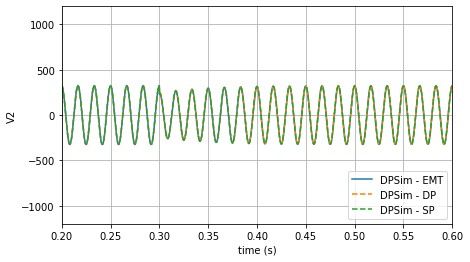

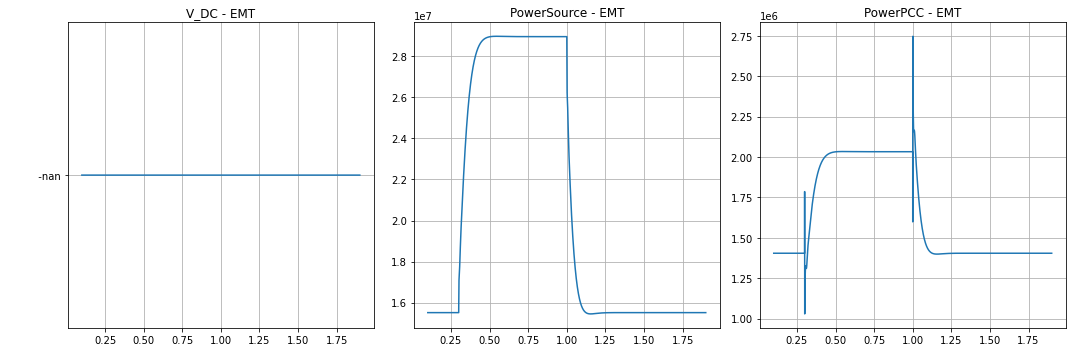

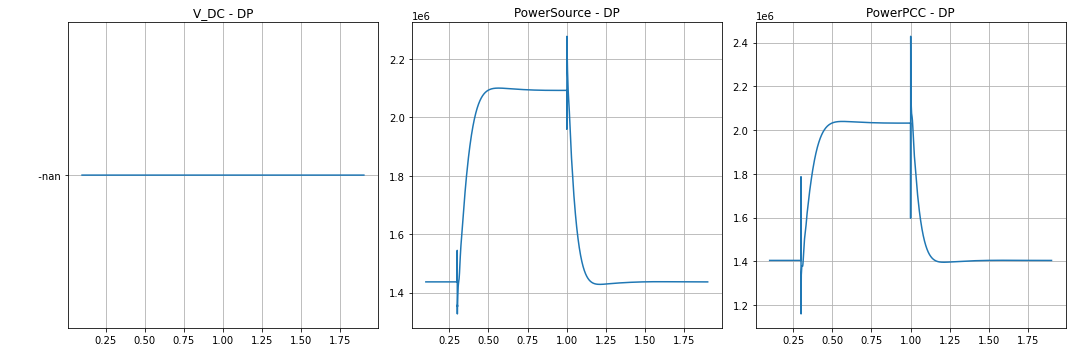

In [10]:
ts_simulink = None
plot_emt_variable('n2.v_0', 'n2.v', 'v2_1', ts_dpsim_emt, ts_dpsim_dp, ts_dpsim_sp, ts_simulink, 'V2', [-1200, 1200], [0.2, 0.6])


data_sets = [ts_dpsim_emt, ts_dpsim_dp]
labels = ['EMT', 'DP']

'''
# Loop through data sets
for i, ts_data in enumerate(data_sets):
    plt.figure(figsize=(15, 5))

    # Loop through subplots
    for j, key in enumerate(['V_DC', 'PowerSource', 'PowerPCC']):
        plt.subplot(1, 3, j + 1)
        plt.plot(ts_data[key].time, ts_data[key].values)
        plt.title(f'{key} - {labels[i]}')
        plt.grid(True)

    plt.tight_layout()

plt.show()
'''

for i, ts_data in enumerate(data_sets):
    plt.figure(figsize=(15, 5))

    # Loop through subplots
    for j, key in enumerate(['V_DC', 'PowerSource', 'PowerPCC']):
        plt.subplot(1, 3, j + 1)
        
        # Slicing the time array for the specified time window
        start_idx = int(len(ts_data[key].time) * 0.05)
        end_idx = int(len(ts_data[key].time) * 0.95)
        time_window = ts_data[key].time[start_idx:end_idx]
        
        plt.plot(time_window, ts_data[key].values[start_idx:end_idx])
        plt.title(f'{key} - {labels[i]}')
        plt.grid(True)

    plt.tight_layout()

plt.show()
